In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, create_gif, clear_temp
from modules.problems import lotkavolterra

import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [12]:
clear_temp()

In [13]:
def f(problem, N_F, loss_history=None):
    zero = torch.tensor([0.], requires_grad=True).to(device)
    t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    return zero, t

problem_number = 4
problem = lotkavolterra.LotkaVolterra.get_problem(problem_number)
name = f'lv{problem_number}_fourier'

L, W = 4, 64
model = FeedForwardNetwork(L, W, output_dim=2, activation=nn.Tanh())
# model.init_weights(init.xavier_normal_)

coef = 0.8

num_iters = 25000
plot_every = 500

problem.train(
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {'lr': 1e-2},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR, 
            'parameters': {'step_size': 50000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {'N_F': 4096},
            'generation_function': f
        },
        'coefs': [[coef], [1 - coef, 1 - coef]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    plotting_params={
        'plot_every': plot_every,
        'save_dir': './.temp/',
        'size': (5, 5),
        'plot_solution': False,
        'plot_freq': True
    },
    name=name,
    show_progress=True
)

Logs will be written to ./logging/lv4_fourier.json.


  0%|          | 0/25000 [00:00<?, ?it/s]

Iter 24999 	 58.286336159859715: 100%|██████████| 25000/25000 [17:53<00:00, 23.30it/s] 


{'final_error': 10.61313536716284, 'duration': 85326}

In [14]:
create_gif(
    [f'.temp/lv4_fourier_iteration_{i}.png' for i in range(0, num_iters, plot_every)],
    '../images/animations/lv/fourier_learning.gif'
)

In [1]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt 

import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

In [2]:
x = torch.linspace(-5, 5, 100)
y1 = torch.tanh(x)
y2 = torch.sin(x)
y3 = x*torch.sigmoid(x)

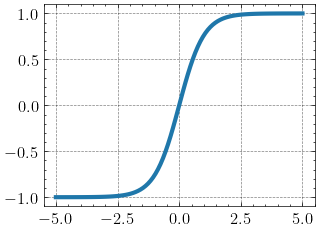

In [17]:
plt.plot(x, y1, linewidth=3, color='#1f77aa')
plt.show()

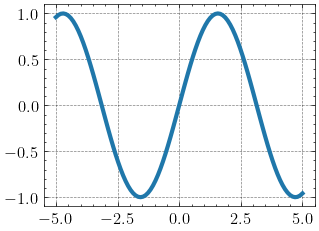

In [16]:
plt.plot(x, y2, linewidth=3, color='#1f77aa')
plt.show()

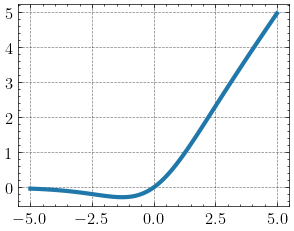

In [15]:
plt.plot(x, y3, linewidth=3, color='#1f77aa')
plt.show()

In [41]:
clear_temp()

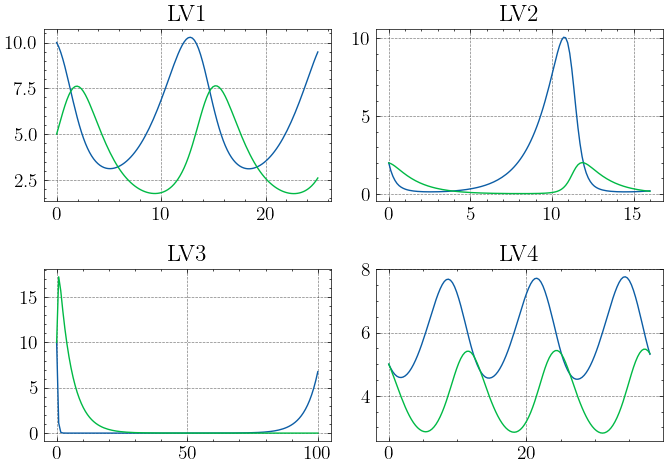

In [4]:
mpl.rcParams["font.size"] = "14"

problems = [lotkavolterra.LotkaVolterra.get_problem(i) for i in range(1, 5)]

size = (7, 5)
fig, axs = plt.subplots(2, 2, figsize=size)
for (i, j), (ind, problem) in zip([(0, 0), (0, 1), (1, 0), (1, 1)], enumerate(problems)):
    axs[i, j].plot(problem.domain, problem.solution[0])
    axs[i, j].plot(problem.domain, problem.solution[1])
    axs[i, j].title.set_text(f'LV{ind+1}')
    
plt.tight_layout()

plt.savefig('../images/lv_grid_2.png', dpi=250)
plt.show()

## Hyperparameter analysis
---

In [1]:
import pandas as pd
from datetime import datetime

def convert(duration):
    time = datetime.strptime(duration[7:], '%H:%M:%S.%f')
    return time.second + time.minute*60 + time.hour*3600

def get_df(name, to_drop, names):
    
    tanh = pd.read_csv(f'./studies/{name}_tanh.csv').drop(to_drop, axis=1)
    tanh['activation'] = 'tanh'
    
    sin = pd.read_csv(f'./studies/{name}_sin.csv').drop(to_drop, axis=1)
    sin['activation'] = 'sin'
    
    swish = pd.read_csv(f'./studies/{name}_swish.csv').drop(to_drop, axis=1)
    swish['activation'] = 'swish'
    
    for df in [tanh, sin, swish]:
        df.columns = names
        df['Duration'] = df['Duration'].apply(convert)
        
    return pd.concat([tanh, sin, swish])

to_drop = ['Unnamed: 0', 'datetime_start', 'datetime_complete', 'state']

In [2]:
lv1 = get_df('lv1', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])
lv2 = get_df('lv2', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])
lv3 = get_df('lv3', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])
lv4 = get_df('lv4', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])

In [4]:
lv1.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
6,6,0.788790,65,4096,0.291763,0.048735,sin
11,11,1.038596,67,4096,0.818880,0.040370,sin
12,12,1.358664,67,3072,0.548232,0.046321,sin
3,3,2.029435,63,1024,0.543518,0.061830,sin
10,10,2.334026,67,1024,0.779726,0.054679,sin


In [5]:
lv1.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,20.712949,65.733333,2730.666667,0.554643,0.040341
swish,7.0,43.209023,77.933333,2184.533333,0.564385,0.037286
tanh,7.0,30.006007,64.666667,2389.333333,0.682023,0.024645


In [6]:
lv1.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,20.378910,1.667619,1377.469868,0.246068,0.024787
swish,4.472136,13.521613,1.907379,853.820813,0.142875,0.026967
tanh,4.472136,17.034561,0.899735,1377.469868,0.317389,0.026200


In [7]:
lv2.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
4,4,14.975401,83,2048,0.275527,0.004245,swish
0,0,15.019612,83,1024,0.303831,0.003241,swish
2,2,15.857010,83,1024,0.925691,0.004173,swish
13,13,18.561841,68,2048,0.950000,0.100000,sin
12,12,18.682517,68,2048,0.587843,0.100000,sin


In [8]:
lv2.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,20.067944,66.933333,2798.933333,0.418809,0.064783
swish,7.0,20.697035,81.200000,1911.466667,0.358428,0.010986
tanh,7.0,20.642620,62.133333,2867.200000,0.300453,0.056883


In [9]:
lv2.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,1.568461,0.798809,1126.178333,0.324017,0.043838
swish,4.472136,2.808103,1.740279,1152.473977,0.248791,0.024872
tanh,4.472136,1.701696,2.924445,1108.301351,0.341489,0.042821


In [10]:
lv3.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
8,8,6.526529,60,4096,0.050000,0.006015,tanh
6,6,6.530860,83,4096,0.472123,0.002355,swish
13,13,6.538309,59,3072,0.328557,0.004787,tanh
11,11,6.539106,59,3072,0.327462,0.002906,tanh
10,10,6.539513,59,4096,0.278794,0.004658,tanh


In [11]:
lv3.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,15.324161,65.466667,2662.400000,0.575286,0.023079
swish,7.0,9.348235,83.200000,3003.733333,0.673159,0.016136
tanh,7.0,8.783004,59.333333,3208.533333,0.434721,0.010034


In [12]:
lv3.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,7.096025,3.067495,1271.928839,0.368191,0.021044
swish,4.472136,2.521845,0.774597,1190.829211,0.262033,0.027368
tanh,4.472136,2.474186,0.617213,1014.200732,0.236459,0.011092


In [13]:
lv4.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
14,14,10.237776,64,1024,0.950000,0.100000,tanh
9,9,10.363218,78,4096,0.860684,0.003689,swish
3,3,10.389698,78,4096,0.824466,0.002765,swish
14,14,10.616750,77,1024,0.950000,0.001000,swish
13,13,10.624718,76,1024,0.950000,0.001000,swish


In [14]:
lv4.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,39.636533,63.866667,3140.266667,0.608675,0.042839
swish,7.0,42.633745,77.666667,3003.733333,0.638420,0.025499
tanh,7.0,42.741843,64.133333,2457.600000,0.709837,0.039489


In [15]:
lv4.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,20.586306,1.684665,1252.146469,0.309400,0.048856
swish,4.472136,20.058822,0.723747,1252.146469,0.340768,0.039779
tanh,4.472136,19.816125,0.351866,1329.511016,0.285495,0.045538
